# MS – Cognitive Function & Trust in AI Chatbots
## Statistical Analysis for MSc Thesis

**Purpose:** Data preparation and statistical analysis examining the relationship between cognitive function, AI perceptions (UTAUT), and trust in AI chatbots among MS patients.

**Author:** Alex  
**Date:** December 2025

---

### Analysis Overview:
1. Data Loading & Cleaning
2. Variable Recoding
3. Composite Score Calculation
4. Reliability Analysis (Cronbach's α)
5. Descriptive Statistics
6. Correlation Analysis
7. Multiple Regression
8. Mediation Analysis
9. Moderation Analysis
10. Visualizations & Export


## 0. Setup & Install Dependencies

Run this cell first to install any missing packages.


In [ ]:
# Run this cell FIRST to install required packages
import sys
%pip install statsmodels pingouin openpyxl seaborn

In [ ]:
# ===============================
# IMPORT LIBRARIES
# ===============================

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Optional: pingouin for mediation
try:
    import pingouin as pg
    HAS_PINGOUIN = True
    print("✓ pingouin installed – mediation analysis available.")
except ImportError:
    HAS_PINGOUIN = False
    print("⚠ pingouin not installed – mediation analysis will be skipped.")
    print("  Install with: pip install pingouin")

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Create output directory
output_dir = Path('analysis_output')
output_dir.mkdir(exist_ok=True)

print(f"\n✓ Libraries loaded successfully")
print(f"✓ Output will be saved to: {output_dir.absolute()}")


✓ pingouin installed – mediation analysis available.

✓ Libraries loaded successfully
✓ Output will be saved to: c:\Users\thodo\Desktop\alex\analysis_output


---
## 1. Load & Parse Data

The CSV file has multi-line headers (rows 1-6), with actual data starting at row 7.


In [ ]:
# ===============================
# LOAD CSV DATA
# ===============================

# Define column names based on the survey structure
column_names = [
    'ID', 'start_time', 'end_time', 'email', 'name', 'last_modified',
    'gender', 'age_group', 'education_years', 'ms_duration', 'ms_type',
    'cfq1', 'cfq2', 'cfq3', 'cfq4', 'cfq5',  # Cognitive Failures (5 items)
    'cload1', 'cload2',  # Cognitive Load (2 items)
    'ai_health_use', 'ai_use_freq', 'ai_purpose',  # AI Experience
    'perf1', 'perf2', 'perf3',  # Performance Expectancy (3 items)
    'eff1', 'eff2', 'eff3',  # Effort Expectancy (3 items)
    'fac1', 'fac2',  # Facilitating Conditions (2 items)
    'trust1', 'trust2', 'trust3', 'trust4', 'trust5_check',  # Trust (4+1 items)
    'comments'  # Open-ended comments
]

# Load CSV, skipping the multi-line header rows
csv_path = "Έρευνα(1-89).xlsx - Sheet1.csv"

df = pd.read_csv(
    csv_path, 
    skiprows=6,  # Skip the header rows (0-5)
    names=column_names,
    encoding='utf-8'
)

print(f"✓ Data loaded successfully")
print(f"  Shape: {df.shape[0]} participants × {df.shape[1]} variables")


✓ Data loaded successfully
  Shape: 84 participants × 35 variables


In [ ]:
# Preview the data
print("First 5 rows of key variables:")
display(df[['ID', 'gender', 'age_group', 'cfq1', 'perf1', 'trust1']].head())

print("\nColumn data types:")
print(df.dtypes)


First 5 rows of key variables:


,ID,gender,age_group,cfq1,perf1,trust1
0,6,Γυναίκα,55–64,2,1,2
1,7,Άνδρας,25–34,2,4,3
2,8,Γυναίκα,35–44,4,3,3
3,9,Γυναίκα,45–54,4,3,3
4,10,Γυναίκα,35–44,4,3,4



Column data types:
ID                   int64
start_time          object
end_time            object
email               object
name               float64
last_modified      float64
gender              object
age_group           object
education_years     object
ms_duration         object
ms_type             object
cfq1                 int64
cfq2                 int64
cfq3                 int64
cfq4                 int64
cfq5                 int64
cload1               int64
cload2               int64
ai_health_use       object
ai_use_freq         object
ai_purpose          object
perf1                int64
perf2                int64
perf3                int64
eff1                 int64
eff2                 int64
eff3                 int64
fac1                 int64
fac2                 int64
trust1               int64
trust2               int64
trust3               int64
trust4               int64
trust5_check         int64
comments            object
dtype: object


---
## 2. Recode Categorical Variables

Convert Greek categorical responses to numeric codes for analysis.


In [ ]:
# ===============================
# RECODE CATEGORICAL VARIABLES
# ===============================

# Gender: 1=Male, 2=Female, 3=Other, 4=Prefer not to say
gender_map = {
    'Άνδρας': 1,
    'Γυναίκα': 2,
    'Άλλο': 3,
    'Δεν επιθυμώ να απαντήσω': 4
}
df['gender_num'] = df['gender'].map(gender_map)

# Age group: ordinal 1-6
age_map = {
    '18–24': 1, '18-24': 1,
    '25–34': 2, '25-34': 2,
    '35–44': 3, '35-44': 3,
    '45–54': 4, '45-54': 4,
    '55–64': 5, '55-64': 5,
    '65+': 6
}
df['age_group_num'] = df['age_group'].map(age_map)

# Education years: ordinal 1-5
edu_map = {
    'Έως 9 έτη (πρωτοβάθμια)': 1,
    '10–12 έτη (δευτεροβάθμια)': 2, '10-12 έτη (δευτεροβάθμια)': 2,
    '13–16 έτη (ανώτατη εκπαίδευση)': 3, '13-16 έτη (ανώτατη εκπαίδευση)': 3,
    '17+ έτη (μεταπτυχιακό/διδακτορικό)': 4,
    'Άλλο': 5
}
df['education_num'] = df['education_years'].map(edu_map)

# MS Duration: ordinal 1-6
ms_dur_map = {
    '< 1 έτος': 1,
    '1–3 έτη': 2, '1-3 έτη': 2,
    '4–6 έτη': 3, '4-6 έτη': 3,
    '7–10 έτη': 4, '7-10 έτη': 4,
    '10 + έτη': 5, '10+ έτη': 5,
    'Δε γνωρίζω': 6, 'Δεν γνωρίζω': 6
}
df['ms_duration_num'] = df['ms_duration'].map(ms_dur_map)

# MS Type
ms_type_map = {
    'Υποτροπιάζουσα-διαλείπουσα (RRMS)': 1,
    'Δευτεροπαθώς προϊούσα (SPMS)': 2,
    'Πρωτοπαθώς προϊούσα (PPMS)': 3,
    'Προϊούσα με υποτροπές (PRMS) / Άλλη μορφή': 4,
    'Δε γνωρίζω': 5, 'Δεν γνωρίζω': 5
}
df['ms_type_num'] = df['ms_type'].map(ms_type_map)

# AI Health Use: binary 0/1
ai_health_map = {
    'Ναι': 1, 'Yes': 1,
    'Όχι': 0, 'No': 0
}
df['ai_health_use_num'] = df['ai_health_use'].map(ai_health_map)

# AI Use Frequency: ordinal 0-4
ai_freq_map = {
    'Καθόλου': 0,
    '1–3 φορές/μήνα': 1, '1-3 φορές/μήνα': 1,
    '1–2 φορές/εβδομάδα': 2, '1-2 φορές/εβδομάδα': 2,
    '3–5 φορές/εβδομάδα': 3, '3-5 φορές/εβδομάδα': 3,
    'Καθημερινά': 4
}
df['ai_use_freq_num'] = df['ai_use_freq'].map(ai_freq_map)

print("✓ Categorical variables recoded")
print("\nCheck unique values:")
print(f"  Gender: {df['gender_num'].value_counts().to_dict()}")
print(f"  Age group: {df['age_group_num'].value_counts().to_dict()}")
print(f"  AI use freq: {df['ai_use_freq_num'].value_counts().to_dict()}")


✓ Categorical variables recoded

Check unique values:
  Gender: {2: 72, 1: 12}
  Age group: {4: 36, 3: 23, 2: 12, 5: 10, 6: 2, 1: 1}
  AI use freq: {1: 26, 0: 18, 2: 17, 3: 14, 4: 9}


---
## 3. Compute Composite Scores

Calculate mean scores for each scale:
- **CFQ**: Cognitive Failures (5 items)
- **CLOAD**: Cognitive Load (2 items)
- **PERF**: Performance Expectancy (3 items)
- **EFF**: Effort Expectancy (3 items)
- **FAC**: Facilitating Conditions (2 items)
- **TRUST_CORE**: Core Trust (4 items)
- **TRUST_CHECK**: Checking Behaviour (1 item)


In [ ]:
# ===============================
# COMPUTE COMPOSITE SCORES
# ===============================

# Ensure Likert items are numeric
likert_cols = ['cfq1', 'cfq2', 'cfq3', 'cfq4', 'cfq5', 
               'cload1', 'cload2',
               'perf1', 'perf2', 'perf3',
               'eff1', 'eff2', 'eff3',
               'fac1', 'fac2',
               'trust1', 'trust2', 'trust3', 'trust4', 'trust5_check']

for col in likert_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Define item lists
cfq_items = ['cfq1', 'cfq2', 'cfq3', 'cfq4', 'cfq5']
cload_items = ['cload1', 'cload2']
perf_items = ['perf1', 'perf2', 'perf3']
eff_items = ['eff1', 'eff2', 'eff3']
fac_items = ['fac1', 'fac2']
trust_core_items = ['trust1', 'trust2', 'trust3', 'trust4']

# Calculate means
df['CFQ_MEAN'] = df[cfq_items].mean(axis=1)
df['CLOAD_MEAN'] = df[cload_items].mean(axis=1)
df['PERF_MEAN'] = df[perf_items].mean(axis=1)
df['EFF_MEAN'] = df[eff_items].mean(axis=1)
df['FAC_MEAN'] = df[fac_items].mean(axis=1)
df['TRUST_CORE'] = df[trust_core_items].mean(axis=1)
df['TRUST_CHECK'] = df['trust5_check']

print("✓ Composite scores computed")
print("\nPreview:")
display(df[['ID', 'CFQ_MEAN', 'CLOAD_MEAN', 'PERF_MEAN', 'EFF_MEAN', 'FAC_MEAN', 'TRUST_CORE', 'TRUST_CHECK']].head(10))


✓ Composite scores computed

Preview:


,ID,CFQ_MEAN,CLOAD_MEAN,PERF_MEAN,EFF_MEAN,FAC_MEAN,TRUST_CORE,TRUST_CHECK
0,6,2.4,3.0,1.000000,1.000000,1.5,1.50,4
1,7,2.2,2.5,3.000000,2.666667,2.5,2.50,4
2,8,4.6,3.5,3.000000,3.333333,3.0,3.00,2
3,9,3.8,2.0,2.000000,4.333333,5.0,3.00,4
4,10,2.6,1.0,3.333333,5.000000,5.0,2.75,5
5,11,1.8,1.0,2.000000,4.000000,4.0,2.75,5
6,12,2.6,1.0,2.666667,4.000000,4.5,2.75,2
7,13,2.6,2.0,2.000000,2.000000,2.0,2.00,5
8,14,1.8,2.5,2.333333,4.666667,4.0,4.00,5
9,15,1.2,1.0,4.000000,5.000000,5.0,4.00,3


---
## 4. Reliability Analysis (Cronbach's Alpha)

Assess internal consistency of each scale.


In [ ]:
# ===============================
# CRONBACH'S ALPHA
# ===============================

def cronbach_alpha(df_items):
    """
    Compute Cronbach's alpha for a set of items.
    Returns alpha and interpretation.
    """
    df_clean = df_items.dropna()
    k = df_clean.shape[1]
    if k < 2:
        return np.nan, "N/A (< 2 items)"
    
    item_variances = df_clean.var(axis=0, ddof=1)
    total_variance = df_clean.sum(axis=1).var(ddof=1)
    
    if total_variance == 0:
        return np.nan, "N/A (zero variance)"
    
    alpha = (k / (k - 1.0)) * (1.0 - item_variances.sum() / total_variance)
    
    # Interpretation
    if alpha >= 0.9:
        interp = "Excellent"
    elif alpha >= 0.8:
        interp = "Good"
    elif alpha >= 0.7:
        interp = "Acceptable"
    elif alpha >= 0.6:
        interp = "Questionable"
    elif alpha >= 0.5:
        interp = "Poor"
    else:
        interp = "Unacceptable"
    
    return alpha, interp

# Calculate alpha for each scale
scales = {
    'Cognitive Failures (CFQ)': cfq_items,
    'Cognitive Load (CLOAD)': cload_items,
    'Performance Expectancy (PERF)': perf_items,
    'Effort Expectancy (EFF)': eff_items,
    'Facilitating Conditions (FAC)': fac_items,
    'Trust Core (TRUST)': trust_core_items
}

reliability_results = []
for scale_name, items in scales.items():
    alpha, interp = cronbach_alpha(df[items])
    reliability_results.append({
        'Scale': scale_name,
        'Items': len(items),
        "Cronbach's α": f"{alpha:.3f}" if not np.isnan(alpha) else "N/A",
        'Interpretation': interp
    })

reliability_df = pd.DataFrame(reliability_results)
print("=" * 60)
print("RELIABILITY ANALYSIS (Cronbach's Alpha)")
print("=" * 60)
display(reliability_df)

# Save to Excel
reliability_df.to_excel(output_dir / 'reliability_analysis.xlsx', index=False)
print(f"\n✓ Saved to: {output_dir / 'reliability_analysis.xlsx'}")


RELIABILITY ANALYSIS (Cronbach's Alpha)


,Scale,Items,Cronbach's α,Interpretation
0,Cognitive Failures (CFQ),5,0.791,Acceptable
1,Cognitive Load (CLOAD),2,0.863,Good
2,Performance Expectancy (PERF),3,0.888,Good
3,Effort Expectancy (EFF),3,0.895,Good
4,Facilitating Conditions (FAC),2,0.647,Questionable
5,Trust Core (TRUST),4,0.902,Excellent



✓ Saved to: analysis_output\reliability_analysis.xlsx


---
## 5. Descriptive Statistics

### 5.1 Demographic & Clinical Characteristics


In [ ]:
# ===============================
# DEMOGRAPHIC FREQUENCIES
# ===============================

def freq_table(series, labels=None):
    """Create frequency table with counts and percentages."""
    counts = series.value_counts(dropna=False).sort_index()
    pcts = (counts / len(series) * 100).round(1)
    result = pd.DataFrame({'n': counts, '%': pcts})
    if labels:
        result.index = result.index.map(labels)
    return result

print("=" * 60)
print("DEMOGRAPHIC & CLINICAL CHARACTERISTICS")
print("=" * 60)

# Gender
print("\n📊 GENDER:")
gender_labels = {1: 'Male', 2: 'Female', 3: 'Other', 4: 'Prefer not to say', np.nan: 'Missing'}
display(freq_table(df['gender_num'], gender_labels))

# Age Group
print("\n📊 AGE GROUP:")
age_labels = {1: '18-24', 2: '25-34', 3: '35-44', 4: '45-54', 5: '55-64', 6: '65+', np.nan: 'Missing'}
display(freq_table(df['age_group_num'], age_labels))

# Education
print("\n📊 EDUCATION LEVEL:")
edu_labels = {1: 'Up to 9 years (primary)', 2: '10-12 years (secondary)', 
              3: '13-16 years (higher)', 4: '17+ years (postgrad)', 5: 'Other', np.nan: 'Missing'}
display(freq_table(df['education_num'], edu_labels))

# MS Duration
print("\n📊 MS DURATION (since diagnosis):")
dur_labels = {1: '<1 year', 2: '1-3 years', 3: '4-6 years', 
              4: '7-10 years', 5: '10+ years', 6: "Don't know", np.nan: 'Missing'}
display(freq_table(df['ms_duration_num'], dur_labels))

# MS Type
print("\n📊 MS TYPE:")
type_labels = {1: 'RRMS', 2: 'SPMS', 3: 'PPMS', 4: 'PRMS/Other', 5: "Don't know", np.nan: 'Missing'}
display(freq_table(df['ms_type_num'], type_labels))

# AI Health Use
print("\n📊 AI CHATBOT USE FOR HEALTH:")
ai_health_labels = {0: 'No', 1: 'Yes', np.nan: 'Missing'}
display(freq_table(df['ai_health_use_num'], ai_health_labels))

# AI Use Frequency
print("\n📊 AI CHATBOT USE FREQUENCY (general):")
ai_freq_labels = {0: 'Not at all', 1: '1-3 times/month', 2: '1-2 times/week', 
                  3: '3-5 times/week', 4: 'Daily', np.nan: 'Missing'}
display(freq_table(df['ai_use_freq_num'], ai_freq_labels))


DEMOGRAPHIC & CLINICAL CHARACTERISTICS

📊 GENDER:


,n,%
gender_num,,
Male,12,14.3
Female,72,85.7



📊 AGE GROUP:


,n,%
age_group_num,,
18-24,1,1.2
25-34,12,14.3
35-44,23,27.4
45-54,36,42.9
55-64,10,11.9
65+,2,2.4



📊 EDUCATION LEVEL:


,n,%
education_num,,
Up to 9 years (primary),4,4.8
10-12 years (secondary),28,33.3
13-16 years (higher),29,34.5
17+ years (postgrad),21,25.0
Other,2,2.4



📊 MS DURATION (since diagnosis):


,n,%
ms_duration_num,,
<1 year,5,6.0
1-3 years,9,10.7
4-6 years,13,15.5
7-10 years,17,20.2
10+ years,40,47.6



📊 MS TYPE:


,n,%
ms_type_num,,
RRMS,39,46.4
SPMS,14,16.7
PPMS,11,13.1
PRMS/Other,2,2.4
Don't know,18,21.4



📊 AI CHATBOT USE FOR HEALTH:


,n,%
ai_health_use_num,,
No,31,36.9
Yes,53,63.1



📊 AI CHATBOT USE FREQUENCY (general):


,n,%
ai_use_freq_num,,
Not at all,18,21.4
1-3 times/month,26,31.0
1-2 times/week,17,20.2
3-5 times/week,14,16.7
Daily,9,10.7


### 5.2 Scale Descriptive Statistics


In [ ]:
# ===============================
# SCALE DESCRIPTIVE STATISTICS
# ===============================

print("=" * 60)
print("DESCRIPTIVE STATISTICS FOR COMPOSITE SCALES")
print("=" * 60)

scale_vars = ['CFQ_MEAN', 'CLOAD_MEAN', 'PERF_MEAN', 'EFF_MEAN', 'FAC_MEAN', 'TRUST_CORE', 'TRUST_CHECK']
scale_labels_dict = {
    'CFQ_MEAN': 'Cognitive Failures',
    'CLOAD_MEAN': 'Cognitive Load',
    'PERF_MEAN': 'Performance Expectancy',
    'EFF_MEAN': 'Effort Expectancy',
    'FAC_MEAN': 'Facilitating Conditions',
    'TRUST_CORE': 'Trust in AI (core)',
    'TRUST_CHECK': 'Checking Behaviour'
}

desc_stats = df[scale_vars].describe().T
desc_stats['Variable'] = desc_stats.index.map(scale_labels_dict)
desc_stats = desc_stats[['Variable', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
desc_stats.columns = ['Variable', 'N', 'Mean', 'SD', 'Min', 'Q1', 'Median', 'Q3', 'Max']
desc_stats = desc_stats.round(2)

display(desc_stats)

# Save
desc_stats.to_excel(output_dir / 'descriptive_statistics.xlsx', index=False)
print(f"\n✓ Saved to: {output_dir / 'descriptive_statistics.xlsx'}")


DESCRIPTIVE STATISTICS FOR COMPOSITE SCALES


,Variable,N,Mean,SD,Min,Q1,Median,Q3,Max
CFQ_MEAN,Cognitive Failures,84.0,2.56,0.91,1.0,1.80,2.60,3.40,4.6
CLOAD_MEAN,Cognitive Load,84.0,2.03,0.82,1.0,1.50,2.00,2.50,4.0
PERF_MEAN,Performance Expectancy,84.0,2.58,1.04,1.0,1.67,2.67,3.33,5.0
EFF_MEAN,Effort Expectancy,84.0,3.71,1.18,1.0,3.00,4.00,4.67,5.0
FAC_MEAN,Facilitating Conditions,84.0,4.02,1.03,1.0,3.50,4.00,5.00,5.0
TRUST_CORE,Trust in AI (core),84.0,2.77,0.96,1.0,2.25,2.75,3.25,5.0
TRUST_CHECK,Checking Behaviour,84.0,3.58,1.51,1.0,2.75,4.00,5.00,5.0



✓ Saved to: analysis_output\descriptive_statistics.xlsx


### 5.3 Visualize Scale Distributions


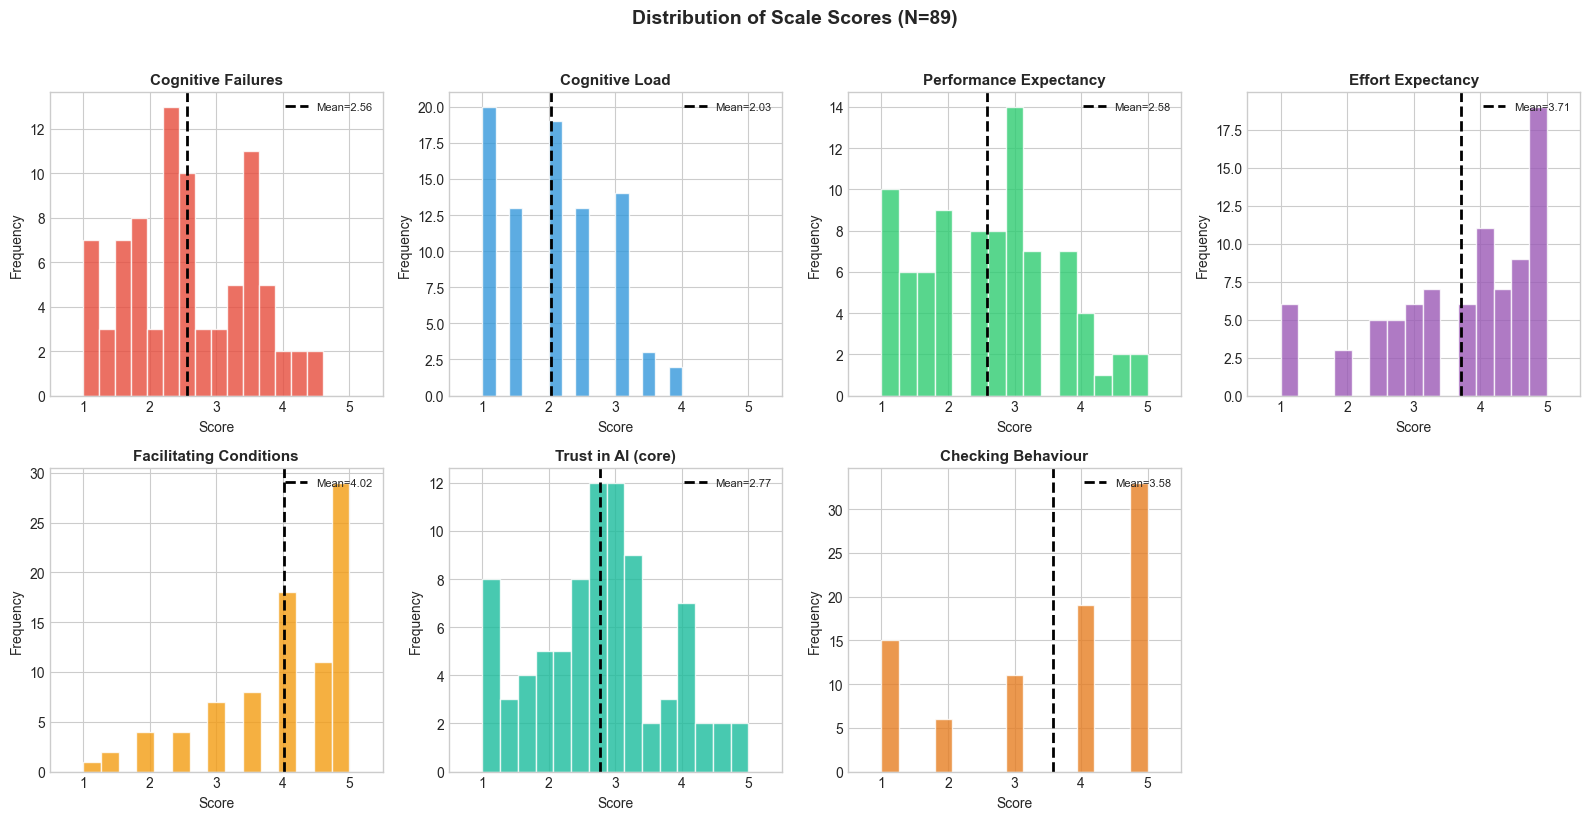


✓ Saved to: analysis_output\scale_distributions.png


In [ ]:
# ===============================
# VISUALIZE SCALE DISTRIBUTIONS
# ===============================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12', '#1ABC9C', '#E67E22']

for i, (var, label) in enumerate(scale_labels_dict.items()):
    ax = axes[i]
    data = df[var].dropna()
    
    ax.hist(data, bins=15, color=colors[i], edgecolor='white', alpha=0.8)
    ax.axvline(data.mean(), color='black', linestyle='--', linewidth=2, label=f'Mean={data.mean():.2f}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 5.5)

# Remove empty subplot
axes[-1].axis('off')

plt.suptitle('Distribution of Scale Scores (N=89)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
plt.savefig(output_dir / 'scale_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'scale_distributions.png'}")


---
## 6. Correlation Analysis

Examine relationships between cognitive function, UTAUT constructs, and trust in AI chatbots.


In [ ]:
# ===============================
# PEARSON CORRELATION MATRIX
# ===============================

print("=" * 60)
print("CORRELATION ANALYSIS (Pearson r)")
print("=" * 60)

corr_vars = [
    'CFQ_MEAN', 'CLOAD_MEAN', 'PERF_MEAN', 'EFF_MEAN', 'FAC_MEAN',
    'TRUST_CORE', 'TRUST_CHECK', 'ai_use_freq_num', 'ai_health_use_num',
    'education_num', 'age_group_num'
]

corr_labels = {
    'CFQ_MEAN': 'CFQ',
    'CLOAD_MEAN': 'CLoad',
    'PERF_MEAN': 'Perf',
    'EFF_MEAN': 'Effort',
    'FAC_MEAN': 'Facil',
    'TRUST_CORE': 'Trust',
    'TRUST_CHECK': 'Check',
    'ai_use_freq_num': 'AI Freq',
    'ai_health_use_num': 'AI Health',
    'education_num': 'Educ',
    'age_group_num': 'Age'
}

# Compute correlation matrix
corr_matrix = df[corr_vars].corr(method='pearson')
corr_matrix_display = corr_matrix.rename(index=corr_labels, columns=corr_labels)

# Display
print("\nCorrelation Matrix:")
display(corr_matrix_display.round(3))

# Save to Excel
corr_matrix_display.round(3).to_excel(output_dir / 'correlation_matrix.xlsx')
print(f"\n✓ Saved to: {output_dir / 'correlation_matrix.xlsx'}")


CORRELATION ANALYSIS (Pearson r)

Correlation Matrix:


,CFQ,CLoad,Perf,Effort,Facil,Trust,Check,AI Freq,AI Health,Educ,Age
CFQ,1.000,0.585,0.147,-0.030,-0.118,0.051,-0.136,0.135,0.117,-0.123,-0.001
CLoad,0.585,1.000,0.162,-0.306,-0.386,-0.034,0.030,-0.053,-0.063,-0.090,0.127
Perf,0.147,0.162,1.000,0.467,0.039,0.618,0.319,0.407,0.358,0.080,-0.052
Effort,-0.030,-0.306,0.467,1.000,0.658,0.622,0.343,0.477,0.422,0.145,-0.151
Facil,-0.118,-0.386,0.039,0.658,1.000,0.250,0.219,0.302,0.231,0.199,-0.281
Trust,0.051,-0.034,0.618,0.622,0.250,1.000,0.375,0.350,0.305,0.004,0.036
Check,-0.136,0.030,0.319,0.343,0.219,0.375,1.000,0.040,0.100,0.090,-0.032
AI Freq,0.135,-0.053,0.407,0.477,0.302,0.350,0.040,1.000,0.616,0.021,-0.318
AI Health,0.117,-0.063,0.358,0.422,0.231,0.305,0.100,0.616,1.000,-0.109,-0.231
Educ,-0.123,-0.090,0.080,0.145,0.199,0.004,0.090,0.021,-0.109,1.000,-0.022



✓ Saved to: analysis_output\correlation_matrix.xlsx


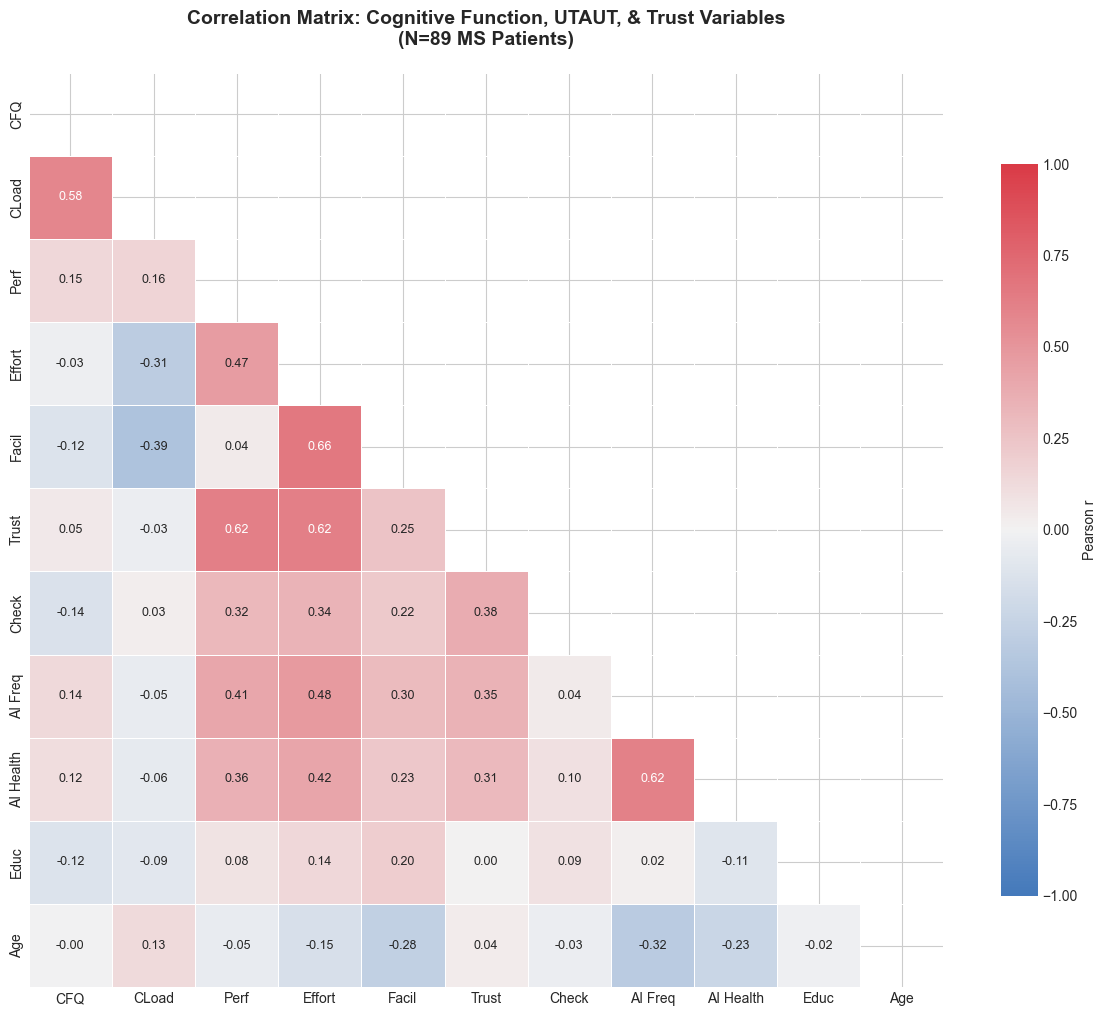


✓ Saved to: analysis_output\correlation_heatmap.png


In [ ]:
# ===============================
# CORRELATION HEATMAP
# ===============================

fig, ax = plt.subplots(figsize=(12, 10))

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix_display, dtype=bool))

# Create heatmap
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(
    corr_matrix_display, 
    mask=mask,
    cmap=cmap, 
    center=0,
    annot=True, 
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Pearson r'},
    annot_kws={'size': 9},
    vmin=-1, vmax=1,
    ax=ax
)

ax.set_title('Correlation Matrix: Cognitive Function, UTAUT, & Trust Variables\n(N=89 MS Patients)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(output_dir / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'correlation_heatmap.png'}")


In [ ]:
# ===============================
# KEY CORRELATIONS WITH P-VALUES
# ===============================

print("\n" + "=" * 60)
print("KEY CORRELATIONS WITH SIGNIFICANCE (p-values)")
print("=" * 60)

# Function to compute correlation with p-value
def corr_with_pvalue(x, y):
    """Compute Pearson correlation with p-value."""
    mask = ~(x.isna() | y.isna())
    r, p = stats.pearsonr(x[mask], y[mask])
    return r, p

# Key relationships of interest
key_pairs = [
    ('CFQ_MEAN', 'TRUST_CORE', 'Cognitive Failures → Trust'),
    ('CLOAD_MEAN', 'TRUST_CORE', 'Cognitive Load → Trust'),
    ('PERF_MEAN', 'TRUST_CORE', 'Performance Expectancy → Trust'),
    ('EFF_MEAN', 'TRUST_CORE', 'Effort Expectancy → Trust'),
    ('FAC_MEAN', 'TRUST_CORE', 'Facilitating Conditions → Trust'),
    ('CFQ_MEAN', 'CLOAD_MEAN', 'Cognitive Failures ↔ Cognitive Load'),
    ('CLOAD_MEAN', 'EFF_MEAN', 'Cognitive Load → Effort Expectancy'),
    ('ai_use_freq_num', 'TRUST_CORE', 'AI Use Frequency → Trust'),
    ('education_num', 'TRUST_CORE', 'Education → Trust'),
]

corr_results = []
for var1, var2, label in key_pairs:
    r, p = corr_with_pvalue(df[var1], df[var2])
    sig = '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else ''
    corr_results.append({
        'Relationship': label,
        'r': f"{r:.3f}",
        'p-value': f"{p:.4f}" if p >= .0001 else "<.0001",
        'Sig.': sig
    })

corr_results_df = pd.DataFrame(corr_results)
display(corr_results_df)

print("\nNote: * p < .05, ** p < .01, *** p < .001")

# Save
corr_results_df.to_excel(output_dir / 'key_correlations.xlsx', index=False)
print(f"\n✓ Saved to: {output_dir / 'key_correlations.xlsx'}")



KEY CORRELATIONS WITH SIGNIFICANCE (p-values)


,Relationship,r,p-value,Sig.
0,Cognitive Failures → Trust,0.051,0.6455,
1,Cognitive Load → Trust,-0.034,0.7602,
2,Performance Expectancy → Trust,0.618,<.0001,***
3,Effort Expectancy → Trust,0.622,<.0001,***
4,Facilitating Conditions → Trust,0.250,0.0217,*
5,Cognitive Failures ↔ Cognitive Load,0.585,<.0001,***
6,Cognitive Load → Effort Expectancy,-0.306,0.0046,**
7,AI Use Frequency → Trust,0.350,0.0011,**
8,Education → Trust,0.004,0.9744,



Note: * p < .05, ** p < .01, *** p < .001

✓ Saved to: analysis_output\key_correlations.xlsx


---
## 7. Regression Analysis: Predicting Trust

Multiple regression model examining predictors of trust in AI chatbots.


In [ ]:
# ===============================
# OLS REGRESSION: PREDICTING TRUST_CORE
# ===============================

print("=" * 60)
print("MULTIPLE REGRESSION: Predicting Trust in AI Chatbots")
print("=" * 60)

# Prepare data (drop rows with missing values in model variables)
model_vars = ['TRUST_CORE', 'CFQ_MEAN', 'CLOAD_MEAN', 'PERF_MEAN', 'EFF_MEAN', 'FAC_MEAN',
              'age_group_num', 'education_num', 'ai_use_freq_num', 'ai_health_use_num']

df_model = df[model_vars].dropna()
print(f"\nSample size for regression: N = {len(df_model)}")

# Fit regression model
reg_formula = (
    'TRUST_CORE ~ CFQ_MEAN + CLOAD_MEAN + PERF_MEAN + EFF_MEAN + FAC_MEAN '
    '+ age_group_num + education_num + ai_use_freq_num + ai_health_use_num'
)

model1 = smf.ols(reg_formula, data=df_model).fit()

print(model1.summary())


MULTIPLE REGRESSION: Predicting Trust in AI Chatbots

Sample size for regression: N = 84
                            OLS Regression Results                            
Dep. Variable:             TRUST_CORE   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     10.04
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           6.56e-10
Time:                        20:27:23   Log-Likelihood:                -81.318
No. Observations:                  84   AIC:                             182.6
Df Residuals:                      74   BIC:                             206.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
# ===============================
# EXTRACT & FORMAT REGRESSION RESULTS
# ===============================

# Create formatted table
reg_table = pd.DataFrame({
    'Variable': model1.params.index,
    'B (Unstd.)': model1.params.values,
    'SE': model1.bse.values,
    't': model1.tvalues.values,
    'p-value': model1.pvalues.values,
    '95% CI Lower': model1.conf_int()[0].values,
    '95% CI Upper': model1.conf_int()[1].values
}).round(4)

# Add significance stars
reg_table['Sig.'] = reg_table['p-value'].apply(
    lambda p: '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else ''
)

# Rename variables for readability
var_names = {
    'Intercept': 'Intercept',
    'CFQ_MEAN': 'Cognitive Failures',
    'CLOAD_MEAN': 'Cognitive Load',
    'PERF_MEAN': 'Performance Expectancy',
    'EFF_MEAN': 'Effort Expectancy',
    'FAC_MEAN': 'Facilitating Conditions',
    'age_group_num': 'Age Group',
    'education_num': 'Education Level',
    'ai_use_freq_num': 'AI Use Frequency',
    'ai_health_use_num': 'AI Use for Health'
}
reg_table['Variable'] = reg_table['Variable'].map(var_names)

print("\n📊 REGRESSION COEFFICIENTS:")
display(reg_table)

# Model fit statistics
print("\n📊 MODEL FIT:")
print(f"  R² = {model1.rsquared:.3f}")
print(f"  Adjusted R² = {model1.rsquared_adj:.3f}")
print(f"  F({model1.df_model:.0f}, {model1.df_resid:.0f}) = {model1.fvalue:.2f}, p = {model1.f_pvalue:.4f}")

# Save regression results
reg_table.to_excel(output_dir / 'regression_results.xlsx', index=False)

# Save summary text
with open(output_dir / 'regression_summary.txt', 'w', encoding='utf-8') as f:
    f.write(model1.summary().as_text())

print(f"\n✓ Saved to: {output_dir / 'regression_results.xlsx'}")
print(f"✓ Saved to: {output_dir / 'regression_summary.txt'}")



📊 REGRESSION COEFFICIENTS:


,Variable,B (Unstd.),SE,t,p-value,95% CI Lower,95% CI Upper,Sig.
0,Intercept,0.3285,0.6174,0.5320,0.5963,-0.9018,1.5588,
1,Cognitive Failures,-0.0289,0.1049,-0.2757,0.7835,-0.2380,0.1801,
2,Cognitive Load,0.0394,0.1289,0.3056,0.7608,-0.2175,0.2963,
3,Performance Expectancy,0.3695,0.0966,3.8261,0.0003,0.1771,0.5620,***
4,Effort Expectancy,0.4045,0.1116,3.6257,0.0005,0.1822,0.6268,***
5,Facilitating Conditions,-0.0291,0.1112,-0.2615,0.7945,-0.2506,0.1925,
6,Age Group,0.1122,0.0820,1.3683,0.1754,-0.0512,0.2755,
7,Education Level,-0.0993,0.0843,-1.1782,0.2425,-0.2673,0.0687,
8,AI Use Frequency,0.0186,0.0809,0.2296,0.8190,-0.1427,0.1798,
9,AI Use for Health,-0.0695,0.2036,-0.3415,0.7337,-0.4753,0.3362,



📊 MODEL FIT:
  R² = 0.550
  Adjusted R² = 0.495
  F(9, 74) = 10.04, p = 0.0000

✓ Saved to: analysis_output\regression_results.xlsx
✓ Saved to: analysis_output\regression_summary.txt


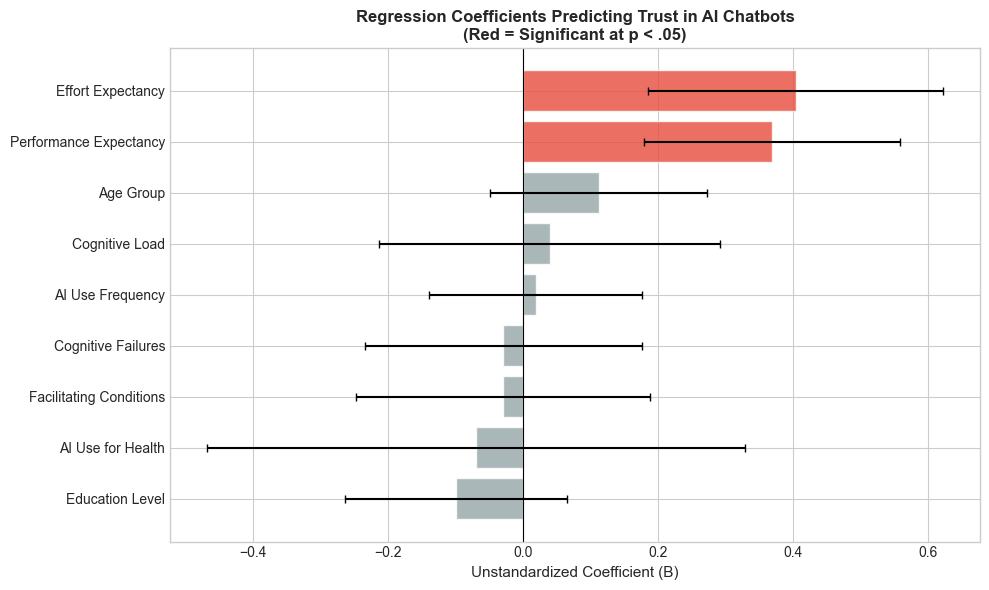


✓ Saved to: analysis_output\regression_coefficients.png


In [ ]:
# ===============================
# REGRESSION COEFFICIENT PLOT
# ===============================

fig, ax = plt.subplots(figsize=(10, 6))

# Exclude intercept
coef_data = reg_table[reg_table['Variable'] != 'Intercept'].copy()
coef_data = coef_data.sort_values('B (Unstd.)')

# Colors based on significance
colors = ['#E74C3C' if sig != '' else '#95A5A6' for sig in coef_data['Sig.']]

y_pos = range(len(coef_data))

# Plot coefficients with error bars
ax.barh(y_pos, coef_data['B (Unstd.)'], xerr=1.96*coef_data['SE'], 
        color=colors, edgecolor='white', alpha=0.8, capsize=3)

ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(coef_data['Variable'])
ax.set_xlabel('Unstandardized Coefficient (B)', fontsize=11)
ax.set_title('Regression Coefficients Predicting Trust in AI Chatbots\n(Red = Significant at p < .05)', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'regression_coefficients.png'}")


---
## 8. Mediation Analysis

Testing whether Effort Expectancy mediates the relationship between Cognitive Load and Trust.

**Model:** Cognitive Load → Effort Expectancy → Trust in AI


In [ ]:
# ===============================
# MEDIATION ANALYSIS
# ===============================

print("=" * 60)
print("MEDIATION ANALYSIS")
print("=" * 60)

print("\nHypothesis: Cognitive Load → Effort Expectancy → Trust in AI")
print("  X (Predictor): CLOAD_MEAN (Cognitive Load)")
print("  M (Mediator): EFF_MEAN (Effort Expectancy)")
print("  Y (Outcome): TRUST_CORE (Trust in AI)")

if HAS_PINGOUIN:
    # Prepare data
    med_vars = ['CLOAD_MEAN', 'EFF_MEAN', 'TRUST_CORE']
    df_med = df[med_vars].dropna()
    print(f"\nSample size: N = {len(df_med)}")
    
    # Run mediation analysis with bootstrapping
    med_results = pg.mediation_analysis(
        data=df_med,
        x='CLOAD_MEAN',
        m='EFF_MEAN',
        y='TRUST_CORE',
        alpha=0.05,
        n_boot=5000,
        seed=42
    )
    
    print("\n📊 MEDIATION RESULTS:")
    display(med_results)
    
    # Save results
    med_results.to_excel(output_dir / 'mediation_analysis.xlsx', index=False)
    print(f"\n✓ Saved to: {output_dir / 'mediation_analysis.xlsx'}")
    
    # Interpretation
    print("\n📝 INTERPRETATION:")
    # Use iloc to get the indirect effect (last row)
    indirect = med_results.iloc[-1]['coef']
    indirect_ci = med_results.iloc[-1][['CI[2.5%]', 'CI[97.5%]']].values
    
    if indirect_ci[0] * indirect_ci[1] > 0:  # Both CI bounds same sign
        print(f"  The indirect effect is SIGNIFICANT (95% CI does not include 0)")
        print(f"  Indirect effect = {indirect:.3f}, 95% CI [{indirect_ci[0]:.3f}, {indirect_ci[1]:.3f}]")
    else:
        print(f"  The indirect effect is NOT significant (95% CI includes 0)")
        print(f"  Indirect effect = {indirect:.3f}, 95% CI [{indirect_ci[0]:.3f}, {indirect_ci[1]:.3f}]")
else:
    print("\n⚠ Skipping mediation analysis (pingouin not installed).")
    print("  Install with: pip install pingouin")


MEDIATION ANALYSIS

Hypothesis: Cognitive Load → Effort Expectancy → Trust in AI
  X (Predictor): CLOAD_MEAN (Cognitive Load)
  M (Mediator): EFF_MEAN (Effort Expectancy)
  Y (Outcome): TRUST_CORE (Trust in AI)

Sample size: N = 84

📊 MEDIATION RESULTS:


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,EFF_MEAN ~ X,-0.442994,0.151945,4.578109e-03,-0.745262,-0.140726,Yes
1,Y ~ EFF_MEAN,0.503792,0.070092,2.768849e-10,0.364358,0.643226,Yes
2,Total,-0.039592,0.129278,7.601865e-01,-0.296768,0.217584,No
3,Direct,0.202615,0.104699,5.645512e-02,-0.005704,0.410934,No
4,Indirect,-0.242207,0.079753,8.000000e-04,-0.416622,-0.104974,Yes



✓ Saved to: analysis_output\mediation_analysis.xlsx

📝 INTERPRETATION:
  The indirect effect is SIGNIFICANT (95% CI does not include 0)
  Indirect effect = -0.242, 95% CI [-0.417, -0.105]


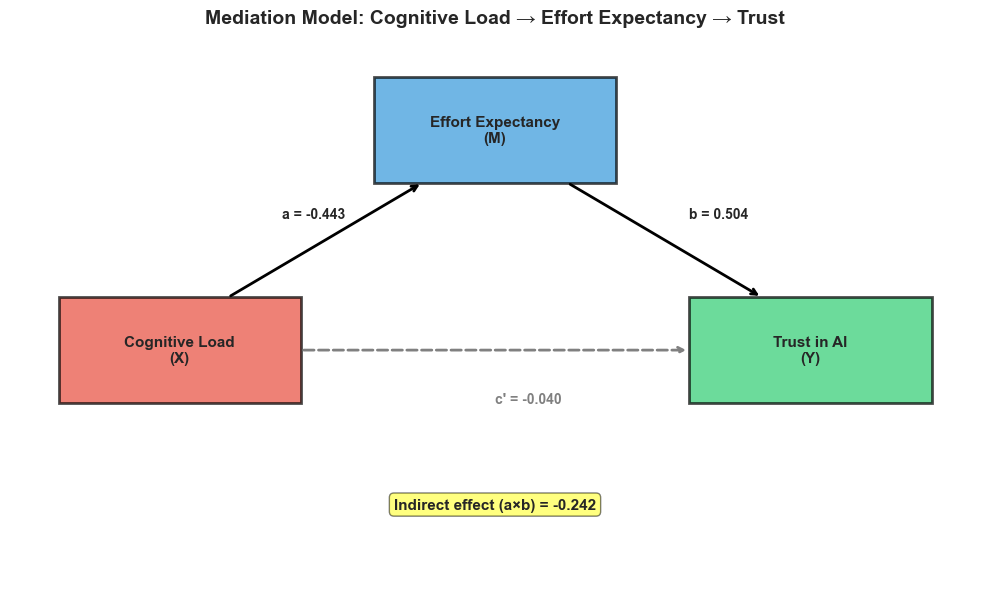


✓ Saved to: analysis_output\mediation_diagram.png


In [ ]:
# ===============================
# MEDIATION DIAGRAM
# ===============================

if HAS_PINGOUIN:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')
    
    # Get coefficients using row index (pingouin returns in fixed order)
    # Row 0: X → M (a path)
    # Row 1: M → Y (b path)  
    # Row 2: X → Y (direct, c' path)
    # Row 3: X → Y (total, c path)
    # Row 4: Indirect effect
    a_path = med_results.iloc[0]['coef']
    b_path = med_results.iloc[1]['coef']
    c_prime = med_results.iloc[2]['coef']
    c_path = med_results.iloc[3]['coef']
    indirect = med_results.iloc[4]['coef']
    
    # Draw boxes
    boxes = [
        {'xy': (0.5, 2), 'width': 2.5, 'height': 1.2, 'label': 'Cognitive Load\n(X)', 'color': '#E74C3C'},
        {'xy': (3.75, 4.5), 'width': 2.5, 'height': 1.2, 'label': 'Effort Expectancy\n(M)', 'color': '#3498DB'},
        {'xy': (7, 2), 'width': 2.5, 'height': 1.2, 'label': 'Trust in AI\n(Y)', 'color': '#2ECC71'}
    ]
    
    for box in boxes:
        rect = plt.Rectangle(box['xy'], box['width'], box['height'], 
                            facecolor=box['color'], edgecolor='black', linewidth=2, alpha=0.7)
        ax.add_patch(rect)
        ax.text(box['xy'][0] + box['width']/2, box['xy'][1] + box['height']/2, 
               box['label'], ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Draw arrows with path coefficients
    # a path: X → M
    ax.annotate('', xy=(4.25, 4.5), xytext=(2.25, 3.2),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax.text(2.8, 4.1, f'a = {a_path:.3f}', fontsize=10, fontweight='bold')
    
    # b path: M → Y
    ax.annotate('', xy=(7.75, 3.2), xytext=(5.75, 4.5),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax.text(7.0, 4.1, f'b = {b_path:.3f}', fontsize=10, fontweight='bold')
    
    # c' path: X → Y (direct)
    ax.annotate('', xy=(7, 2.6), xytext=(3, 2.6),
                arrowprops=dict(arrowstyle='->', color='gray', lw=2, ls='--'))
    ax.text(5, 2.0, f"c' = {c_prime:.3f}", fontsize=10, fontweight='bold', color='gray')
    
    # Indirect effect annotation
    ax.text(5, 0.8, f'Indirect effect (a×b) = {indirect:.3f}', 
           fontsize=11, fontweight='bold', ha='center', 
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    ax.set_title('Mediation Model: Cognitive Load → Effort Expectancy → Trust', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'mediation_diagram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved to: {output_dir / 'mediation_diagram.png'}")


---
## 9. Moderation Analysis

Testing whether AI Use Frequency moderates the relationship between Effort Expectancy and Trust.


In [ ]:
# ===============================
# MODERATION ANALYSIS
# ===============================

print("=" * 60)
print("MODERATION ANALYSIS")
print("=" * 60)

print("\nHypothesis: AI Use Frequency moderates the relationship between")
print("            Effort Expectancy and Trust in AI")
print("\n  X: EFF_MEAN (Effort Expectancy)")
print("  W: ai_use_freq_num (AI Use Frequency)")
print("  Y: TRUST_CORE (Trust in AI)")

# Prepare data
mod_vars = ['EFF_MEAN', 'ai_use_freq_num', 'TRUST_CORE']
df_mod = df[mod_vars].dropna()

# Center predictors for interpretation
df_mod['EFF_c'] = df_mod['EFF_MEAN'] - df_mod['EFF_MEAN'].mean()
df_mod['AI_c'] = df_mod['ai_use_freq_num'] - df_mod['ai_use_freq_num'].mean()

# Create interaction term
df_mod['EFF_x_AI'] = df_mod['EFF_c'] * df_mod['AI_c']

print(f"\nSample size: N = {len(df_mod)}")

# Fit moderation model
mod_formula = 'TRUST_CORE ~ EFF_c + AI_c + EFF_x_AI'
mod_model = smf.ols(mod_formula, data=df_mod).fit()

print("\n📊 MODERATION MODEL RESULTS:")
print(mod_model.summary())


MODERATION ANALYSIS

Hypothesis: AI Use Frequency moderates the relationship between
            Effort Expectancy and Trust in AI

  X: EFF_MEAN (Effort Expectancy)
  W: ai_use_freq_num (AI Use Frequency)
  Y: TRUST_CORE (Trust in AI)

Sample size: N = 84

📊 MODERATION MODEL RESULTS:
                            OLS Regression Results                            
Dep. Variable:             TRUST_CORE   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     17.44
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           8.33e-09
Time:                        20:27:25   Log-Likelihood:                -93.684
No. Observations:                  84   AIC:                             195.4
Df Residuals:                      80   BIC:                             205.1
Df Model:                           3                                         
Cov

In [ ]:
# ===============================
# FORMAT MODERATION RESULTS
# ===============================

mod_table = pd.DataFrame({
    'Variable': ['Intercept', 'Effort Expectancy (centered)', 'AI Use Frequency (centered)', 'Interaction (EFF × AI)'],
    'B': mod_model.params.values,
    'SE': mod_model.bse.values,
    't': mod_model.tvalues.values,
    'p-value': mod_model.pvalues.values,
    '95% CI Lower': mod_model.conf_int()[0].values,
    '95% CI Upper': mod_model.conf_int()[1].values
}).round(4)

mod_table['Sig.'] = mod_table['p-value'].apply(
    lambda p: '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else ''
)

print("\n📊 MODERATION COEFFICIENTS:")
display(mod_table)

print("\n📊 MODEL FIT:")
print(f"  R² = {mod_model.rsquared:.3f}")
print(f"  F({mod_model.df_model:.0f}, {mod_model.df_resid:.0f}) = {mod_model.fvalue:.2f}, p = {mod_model.f_pvalue:.4f}")

# Interpretation
interaction_p = mod_model.pvalues['EFF_x_AI']
print("\n📝 INTERPRETATION:")
if interaction_p < 0.05:
    print(f"  The interaction is SIGNIFICANT (p = {interaction_p:.4f})")
    print("  → AI Use Frequency DOES moderate the Effort-Trust relationship.")
else:
    print(f"  The interaction is NOT significant (p = {interaction_p:.4f})")
    print("  → AI Use Frequency does NOT significantly moderate the Effort-Trust relationship.")

# Save
mod_table.to_excel(output_dir / 'moderation_results.xlsx', index=False)
print(f"\n✓ Saved to: {output_dir / 'moderation_results.xlsx'}")



📊 MODERATION COEFFICIENTS:


,Variable,B,SE,t,p-value,95% CI Lower,95% CI Upper,Sig.
0,Intercept,2.7370,0.0937,29.1968,0.0000,2.5504,2.9235,***
1,Effort Expectancy (centered),0.5164,0.0933,5.5362,0.0000,0.3307,0.7020,***
2,AI Use Frequency (centered),0.0389,0.0751,0.5186,0.6055,-0.1105,0.1883,
3,Interaction (EFF × AI),0.0516,0.0623,0.8284,0.4099,-0.0723,0.1755,



📊 MODEL FIT:
  R² = 0.395
  F(3, 80) = 17.44, p = 0.0000

📝 INTERPRETATION:
  The interaction is NOT significant (p = 0.4099)
  → AI Use Frequency does NOT significantly moderate the Effort-Trust relationship.

✓ Saved to: analysis_output\moderation_results.xlsx


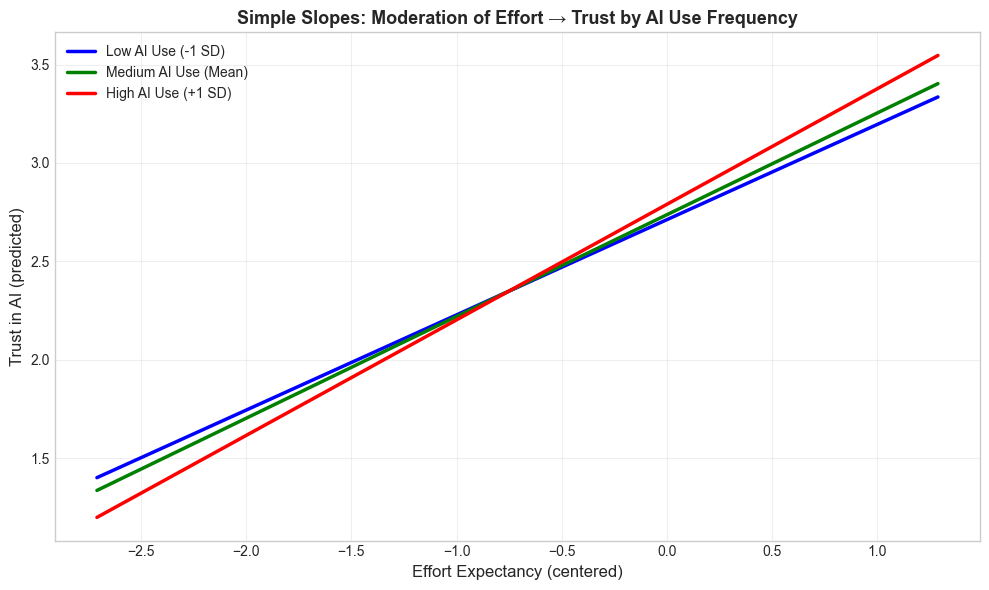


✓ Saved to: analysis_output\moderation_simple_slopes.png


In [ ]:
# ===============================
# SIMPLE SLOPES PLOT (MODERATION)
# ===============================

fig, ax = plt.subplots(figsize=(10, 6))

# Define levels of moderator (Low, Medium, High AI use)
ai_low = df_mod['AI_c'].quantile(0.25)  # 25th percentile
ai_med = 0  # Mean (since centered)
ai_high = df_mod['AI_c'].quantile(0.75)  # 75th percentile

# Create range of X values
eff_range = np.linspace(df_mod['EFF_c'].min(), df_mod['EFF_c'].max(), 100)

# Calculate predicted Y for each level of moderator
b0 = mod_model.params['Intercept']
b1 = mod_model.params['EFF_c']
b2 = mod_model.params['AI_c']
b3 = mod_model.params['EFF_x_AI']

y_low = b0 + b1*eff_range + b2*ai_low + b3*eff_range*ai_low
y_med = b0 + b1*eff_range + b2*ai_med + b3*eff_range*ai_med
y_high = b0 + b1*eff_range + b2*ai_high + b3*eff_range*ai_high

# Plot simple slopes
ax.plot(eff_range, y_low, 'b-', linewidth=2.5, label='Low AI Use (-1 SD)')
ax.plot(eff_range, y_med, 'g-', linewidth=2.5, label='Medium AI Use (Mean)')
ax.plot(eff_range, y_high, 'r-', linewidth=2.5, label='High AI Use (+1 SD)')

ax.set_xlabel('Effort Expectancy (centered)', fontsize=12)
ax.set_ylabel('Trust in AI (predicted)', fontsize=12)
ax.set_title('Simple Slopes: Moderation of Effort → Trust by AI Use Frequency', 
            fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'moderation_simple_slopes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'moderation_simple_slopes.png'}")


---
## 10. Additional Visualizations

### 10.1 Key Relationship Scatter Plots


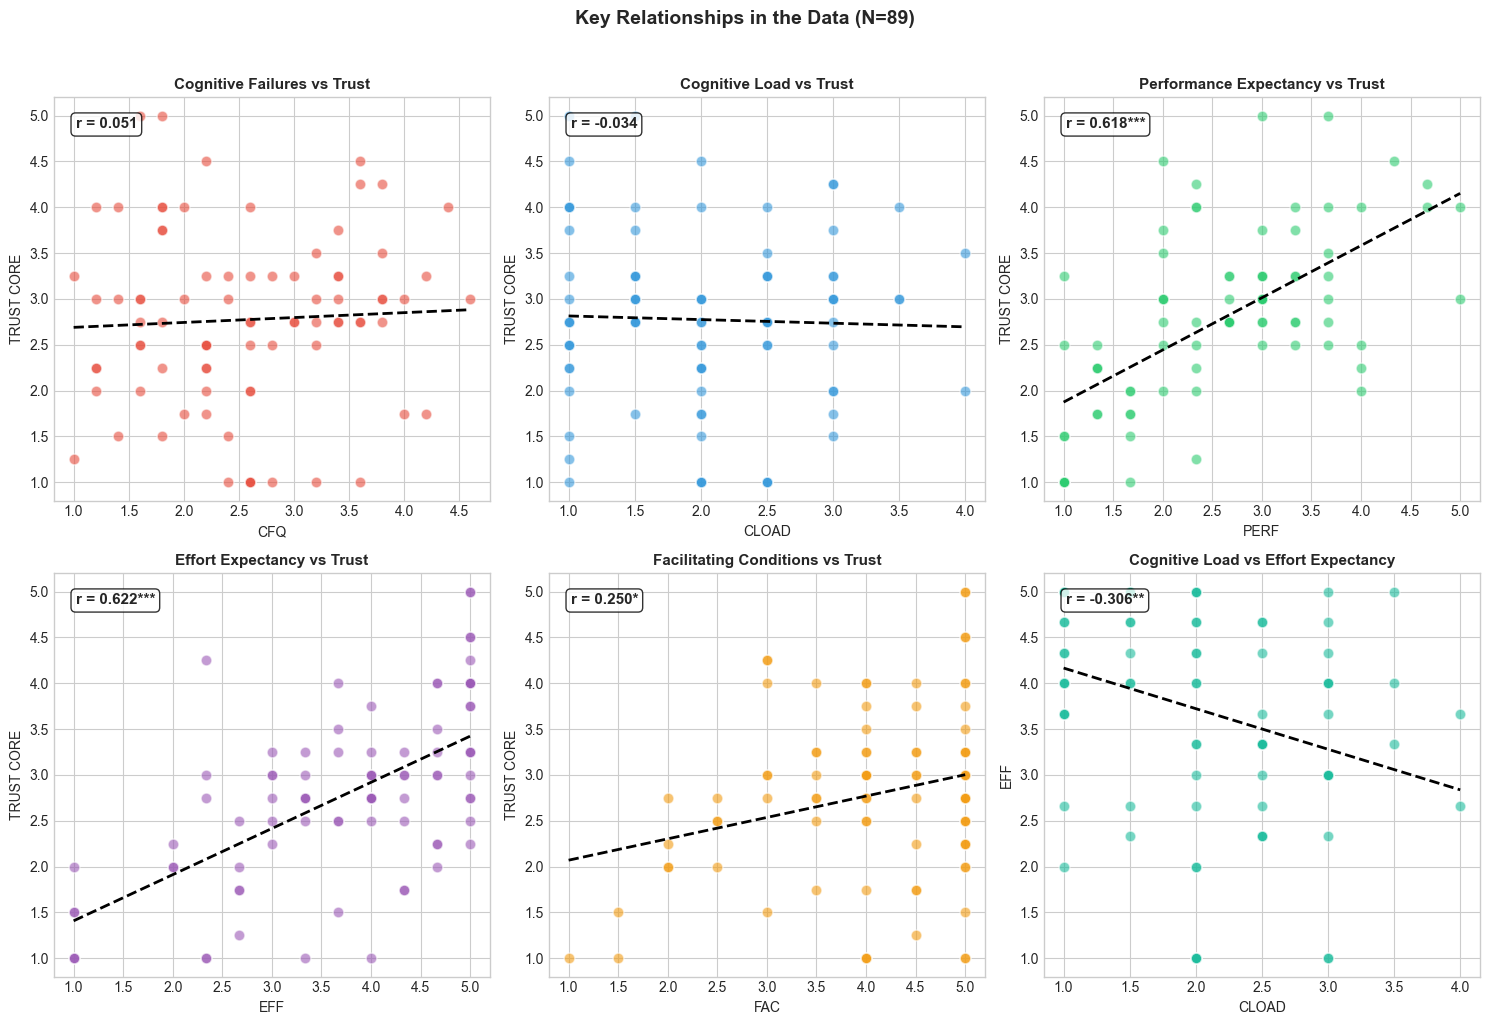


✓ Saved to: analysis_output\scatter_plots.png


In [ ]:
# ===============================
# SCATTER PLOTS: KEY RELATIONSHIPS
# ===============================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

relationships = [
    ('CFQ_MEAN', 'TRUST_CORE', 'Cognitive Failures vs Trust'),
    ('CLOAD_MEAN', 'TRUST_CORE', 'Cognitive Load vs Trust'),
    ('PERF_MEAN', 'TRUST_CORE', 'Performance Expectancy vs Trust'),
    ('EFF_MEAN', 'TRUST_CORE', 'Effort Expectancy vs Trust'),
    ('FAC_MEAN', 'TRUST_CORE', 'Facilitating Conditions vs Trust'),
    ('CLOAD_MEAN', 'EFF_MEAN', 'Cognitive Load vs Effort Expectancy')
]

colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12', '#1ABC9C']

for idx, (x_var, y_var, title) in enumerate(relationships):
    ax = axes.flatten()[idx]
    
    # Remove NaN
    mask = ~(df[x_var].isna() | df[y_var].isna())
    x = df.loc[mask, x_var]
    y = df.loc[mask, y_var]
    
    # Scatter plot
    ax.scatter(x, y, c=colors[idx], alpha=0.6, edgecolors='white', s=60)
    
    # Regression line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), color='black', linestyle='--', linewidth=2)
    
    # Correlation coefficient
    r, pval = stats.pearsonr(x, y)
    sig = '***' if pval < .001 else '**' if pval < .01 else '*' if pval < .05 else ''
    ax.text(0.05, 0.95, f'r = {r:.3f}{sig}', transform=ax.transAxes, 
           fontsize=11, fontweight='bold', va='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel(x_var.replace('_MEAN', '').replace('_', ' '))
    ax.set_ylabel(y_var.replace('_MEAN', '').replace('_', ' '))
    ax.set_title(title, fontsize=11, fontweight='bold')

plt.suptitle('Key Relationships in the Data (N=89)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(output_dir / 'scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'scatter_plots.png'}")


### 10.2 Demographic Visualizations


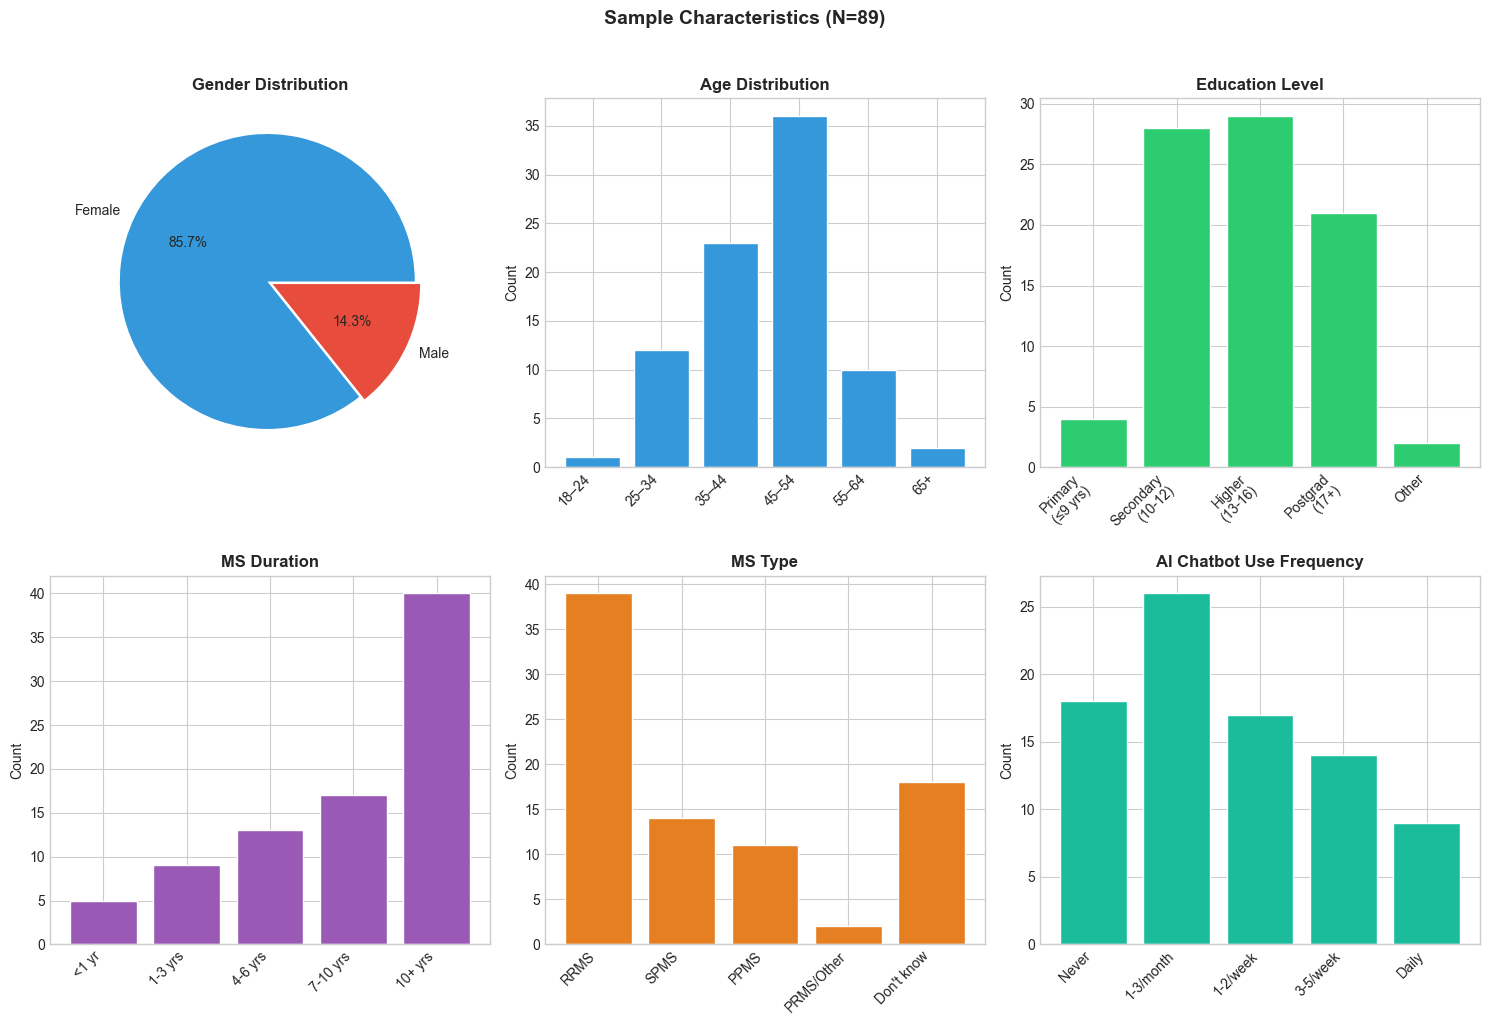


✓ Saved to: analysis_output\demographics.png


In [ ]:
# ===============================
# DEMOGRAPHIC VISUALIZATIONS
# ===============================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Gender
ax = axes[0, 0]
gender_counts = df['gender'].value_counts()
colors_gender = ['#3498DB', '#E74C3C', '#95A5A6']
wedges, texts, autotexts = ax.pie(gender_counts, labels=['Female', 'Male', 'Other'][:len(gender_counts)], 
                                   autopct='%1.1f%%', colors=colors_gender[:len(gender_counts)], 
                                   explode=[0.02]*len(gender_counts))
ax.set_title('Gender Distribution', fontweight='bold')

# Age Group
ax = axes[0, 1]
age_order = ['18–24', '25–34', '35–44', '45–54', '55–64', '65+']
age_counts = df['age_group'].value_counts()
age_counts = age_counts.reindex([a for a in age_order if a in age_counts.index])
ax.bar(range(len(age_counts)), age_counts.values, color='#3498DB', edgecolor='white')
ax.set_xticks(range(len(age_counts)))
ax.set_xticklabels(age_counts.index, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Age Distribution', fontweight='bold')

# Education
ax = axes[0, 2]
edu_counts = df['education_num'].value_counts().sort_index().dropna()
edu_labels = ['Primary\n(≤9 yrs)', 'Secondary\n(10-12)', 'Higher\n(13-16)', 'Postgrad\n(17+)', 'Other']
ax.bar(range(len(edu_counts)), edu_counts.values, color='#2ECC71', edgecolor='white')
ax.set_xticks(range(len(edu_counts)))
ax.set_xticklabels(edu_labels[:len(edu_counts)], rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Education Level', fontweight='bold')

# MS Duration
ax = axes[1, 0]
dur_counts = df['ms_duration_num'].value_counts().sort_index().dropna()
dur_labels = ['<1 yr', '1-3 yrs', '4-6 yrs', '7-10 yrs', '10+ yrs', "Don't know"]
ax.bar(range(len(dur_counts)), dur_counts.values, color='#9B59B6', edgecolor='white')
ax.set_xticks(range(len(dur_counts)))
ax.set_xticklabels(dur_labels[:len(dur_counts)], rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('MS Duration', fontweight='bold')

# MS Type
ax = axes[1, 1]
type_counts = df['ms_type_num'].value_counts().sort_index().dropna()
type_labels = ['RRMS', 'SPMS', 'PPMS', 'PRMS/Other', "Don't know"]
ax.bar(range(len(type_counts)), type_counts.values, color='#E67E22', edgecolor='white')
ax.set_xticks(range(len(type_counts)))
ax.set_xticklabels(type_labels[:len(type_counts)], rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('MS Type', fontweight='bold')

# AI Use Frequency
ax = axes[1, 2]
ai_counts = df['ai_use_freq_num'].value_counts().sort_index().dropna()
ai_labels = ['Never', '1-3/month', '1-2/week', '3-5/week', 'Daily']
ax.bar(range(len(ai_counts)), ai_counts.values, color='#1ABC9C', edgecolor='white')
ax.set_xticks(range(len(ai_counts)))
ax.set_xticklabels(ai_labels[:len(ai_counts)], rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('AI Chatbot Use Frequency', fontweight='bold')

plt.suptitle('Sample Characteristics (N=89)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(output_dir / 'demographics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'demographics.png'}")


---
## 11. Export Cleaned Data


In [ ]:
# ===============================
# EXPORT CLEANED DATASET
# ===============================

print("=" * 60)
print("EXPORTING CLEANED DATA")
print("=" * 60)

# Select columns to export
export_cols = [
    'ID', 'gender', 'gender_num', 'age_group', 'age_group_num', 
    'education_years', 'education_num', 'ms_duration', 'ms_duration_num',
    'ms_type', 'ms_type_num',
    'cfq1', 'cfq2', 'cfq3', 'cfq4', 'cfq5', 'CFQ_MEAN',
    'cload1', 'cload2', 'CLOAD_MEAN',
    'ai_health_use', 'ai_health_use_num', 'ai_use_freq', 'ai_use_freq_num',
    'perf1', 'perf2', 'perf3', 'PERF_MEAN',
    'eff1', 'eff2', 'eff3', 'EFF_MEAN',
    'fac1', 'fac2', 'FAC_MEAN',
    'trust1', 'trust2', 'trust3', 'trust4', 'TRUST_CORE',
    'trust5_check', 'TRUST_CHECK',
    'comments'
]

df_export = df[export_cols].copy()

# Save to Excel
df_export.to_excel(output_dir / 'cleaned_data_with_scores.xlsx', index=False)
print(f"\n✓ Cleaned data saved to: {output_dir / 'cleaned_data_with_scores.xlsx'}")

# Also save as CSV
df_export.to_csv(output_dir / 'cleaned_data_with_scores.csv', index=False, encoding='utf-8-sig')
print(f"✓ CSV version saved to: {output_dir / 'cleaned_data_with_scores.csv'}")


EXPORTING CLEANED DATA

✓ Cleaned data saved to: analysis_output\cleaned_data_with_scores.xlsx
✓ CSV version saved to: analysis_output\cleaned_data_with_scores.csv


---
## 12. Summary of All Output Files


In [ ]:
# ===============================
# SUMMARY OF OUTPUT FILES
# ===============================

print("=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)

print(f"\n📁 All outputs saved to: {output_dir.absolute()}")
print("\n📋 Files created:")

for f in sorted(output_dir.iterdir()):
    size = f.stat().st_size / 1024  # KB
    print(f"   • {f.name} ({size:.1f} KB)")

print("\n" + "=" * 60)
print("KEY FINDINGS SUMMARY")
print("=" * 60)

print(f"\n📊 SAMPLE: N = {len(df)} MS patients")

print(f"\n📊 RELIABILITY (Cronbach's α):")
for _, row in reliability_df.iterrows():
    alpha_val = row["Cronbach's α"]
    print(f"   • {row['Scale']}: α = {alpha_val} ({row['Interpretation']})")

print(f"\n📊 REGRESSION MODEL (R² = {model1.rsquared:.3f}):")
sig_predictors = reg_table[reg_table['Sig.'] != ''][['Variable', 'B (Unstd.)', 'p-value', 'Sig.']]
if len(sig_predictors) > 1:  # Exclude intercept
    print("   Significant predictors of Trust:")
    for _, row in sig_predictors.iterrows():
        if row['Variable'] != 'Intercept':
            print(f"   • {row['Variable']}: B = {row['B (Unstd.)']}, p {row['Sig.']}")
else:
    print("   No significant predictors found (excluding intercept).")

print("\n✅ Analysis notebook execution complete!")


SyntaxError: unexpected character after line continuation character (603069805.py, line 24)